In [2]:
import pandas as pd
from scipy.stats import skew
from scipy.stats import kurtosis
import statistics
import numpy as np
from sklearn.model_selection import train_test_split
import datetime
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import shap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense

In [3]:
def ReadCSV(path):
    data = pd.read_csv(path)
    return data

In [4]:
def splitData(df):
    total_size=len(df)
    split = 0.3
    train_size=math.floor(split*total_size)
    train=df.head(train_size)
    test=df.tail(len(df) -train_size)
    return train, test

In [5]:
def LinReg(df):
    y = df['Price']
    reg = LinearRegression().fit(df,y)
    return reg

In [6]:
def Plot(Y, pred):
    plt.plot(Y, color='blue', label = 'Actual Value')
    plt.plot(pred, color='fuchsia', label='Predicted Value')
    plt.title('Actual Price vs Predicted Price')
    plt.xlabel('year')
    plt.ylabel('GLD Price')
    plt.legend()
    plt.show()

In [7]:
def Performance(Y, pred, model):
    rmse = np.sqrt(mean_squared_error(Y, pred))
    mse = mean_squared_error(Y, pred)
    mae = mean_absolute_error(Y, pred)
    r = r2_score(Y, pred)
    print("Performance obtained by" + model)
    print("***************************************")
    print("***************************************")
    print("** RMSE: %f   " % (rmse))
    print("** MSE: %f    " % (mse)) 
    print("** MAE: %f    " % (mae)) 
    print("** R2 Score: %f " % (r))
    print("***************************************")
    print("***************************************")

In [8]:
def SHAPBeeswarm(model, X_train, X_test):
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)
    shap.plots.beeswarm(shap_values)

In [9]:
def SHAPDepPlot(model, X):
    explainer = shap.TreeExplainer(model,X)
    shap_values = explainer.shap_values(X)
    shap.dependence_plot(0, shap_values, X)
    shap.dependence_plot(1, shap_values, X)
    shap.dependence_plot(2, shap_values, X)
    shap.dependence_plot(3, shap_values, X)
    shap.dependence_plot(4, shap_values, X)

In [10]:
def SHAPBarPlot(model, X_test, X_train):
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)
    shap.plots.bar(shap_values)

In [57]:
def SHAPForcePlot(model, X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)    
    shap_plot = shap.force_plot(explainer.expected_value,shap_values[150], features=X.iloc[150],feature_names=X.columns, matplotlib=True, show=False)

In [12]:
#Load Silver Prices
Silver = ReadCSV('Silver_Price.csv')
Silver = Silver[['Date', 'Price']]
Silver['Date'] = pd.to_datetime(Silver['Date'])
Silver = Silver.reset_index()


#Load Crude Oil Prices
COil = ReadCSV('CrudeOil_Price.csv')
COil['Date'].apply(lambda x: datetime.datetime.strptime(x, '%m-%d-%Y') if type(x)==str else np.NaN)
COil['Date'] = pd.to_datetime(COil['Date'])
COil = COil.reset_index()

#Load Gold Prices (different method cause it's a xlsx file)
Gold = pd.read_excel('Gold_Price.xlsx', sheet_name = "Monthly_Average",usecols = "D,E")
#Resize Gold Prices to select the desired period of time
Gold = Gold.drop(labels=range(0, 93), axis=0)
Gold = Gold.drop(labels=range(501, 524), axis=0)
Gold.rename(columns = {'Unnamed: 3':'Date', 'Unnamed: 4':'Price','Unnamed: 5':'EUR', 'Unnamed: 6':'GBP', 'Unnamed: 7':'JPN'}, inplace = True)
Gold = Gold.loc[::-1]
Gold = Gold.reset_index()


#Load USD-EUR
USD_EUR = ReadCSV('USD-EUR.csv')
USD_EUR['Date'] = pd.to_datetime(USD_EUR['Date'])
USD_EUR = USD_EUR.reset_index()

#Load USD-CNY
USD_CNY = ReadCSV('USD-CNY.csv')
USD_CNY['Date'] = pd.to_datetime(USD_CNY['Date'])
USD_CNY = USD_CNY.loc[::-1]
USD_CNY = USD_CNY.reset_index()

#Load SP_500 data
SP_500 = ReadCSV('SP_500.csv')
SP_500 = SP_500.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
SP_500 = SP_500[['Date','Price']]
SP_500.astype({'Price': 'double'}).dtypes
SP_500['Date'] = pd.to_datetime(SP_500['Date'])



In [13]:
Indicators = {   '' :["Mean", "Median", "Maximum", "Minimum", "Std.Dev", "Skewnness","Kurtosis"],
              'Gold' :[statistics.mean(Gold['Price']), statistics.median(Gold['Price']), max(Gold['Price']), min(Gold['Price']), statistics.stdev(Gold['Price']),skew(Gold['Price']),kurtosis(Gold['Price'], fisher= True)],
              #'Inflation' :[statistics.mean(Inflaction['Price']),statistics.median(Inflaction['Price']), max(Inflaction['Price']), min(Inflaction['Price'])],
              'Oil' :[statistics.mean(COil['Price']), statistics.median(COil['Price']),max(COil['Price']), min(COil['Price']), statistics.stdev(COil['Price']),skew(COil['Price']), kurtosis(COil['Price'])],
              'Silver' :[statistics.mean(Silver['Price']), statistics.median(Silver['Price']),max(Silver['Price']), min(Silver['Price']), statistics.stdev(Silver['Price']),skew(Silver['Price']),kurtosis(Silver['Price'])],
              'SP_500' :[statistics.mean(SP_500['Price']), statistics.median(SP_500['Price']),max(SP_500['Price']), min(SP_500['Price']), statistics.stdev(SP_500['Price']),skew(SP_500['Price']),kurtosis(SP_500['Price'])],
              'USD_CNY' :[statistics.mean(USD_CNY['Price']),statistics.median(USD_CNY['Price']),max(USD_CNY['Price']), min(USD_CNY['Price']), statistics.stdev(USD_CNY['Price']),abs(skew(USD_CNY['Price'])),kurtosis(USD_CNY['Price'])],
              'USD_EUR': [statistics.mean(USD_EUR['Price']),statistics.median(USD_EUR['Price']),max(USD_EUR['Price']), min(USD_EUR['Price']), statistics.stdev(USD_EUR['Price']),abs(skew(USD_EUR['Price'])),kurtosis(USD_EUR['Price'])]}
           
Indicators = pd.DataFrame(Indicators)
Indicators = Indicators.set_index('')


In [14]:
Indicators

,Gold,Oil,Silver,SP_500,USD_CNY,USD_EUR
,,,,,,
Mean,700.910711,44.177745,10.954907,1151.387500,6.775339,1.196931
Median,417.270000,31.185000,6.472500,1123.445000,6.831200,1.201726
Maximum,1771.850000,133.880000,48.584000,3230.780000,8.725100,1.576970
Minimum,256.080000,11.350000,3.565000,129.230000,3.201400,0.853167
Std.Dev,453.737730,29.148175,8.219380,712.452281,1.532930,0.146036
Skewnness,0.800667,0.865415,1.514493,0.763613,0.722544,0.172422
Kurtosis,-0.908533,-0.388403,2.185075,0.043801,-0.450655,-0.168754


In [15]:
columns = [Silver["Price"], COil["Price"], SP_500["Price"],USD_EUR["Price"], USD_CNY["Price"]]

headers = ["Silver", "COil", "SP_500", "USD_EUR", "USD_CNY"]

data = pd.concat(columns, axis=1, keys=headers)

In [16]:
data

,Silver,COil,SP_500,USD_EUR,USD_CNY
0,18.404,59.88,3230.78,1.111345,7.0137
1,17.626,57.03,3140.98,1.105095,7.0199
2,18.699,53.96,3037.56,1.105257,7.0961
3,17.583,56.95,2976.74,1.100390,7.1137
4,18.877,54.81,2926.46,1.112623,7.0629
...,...,...,...,...,...
403,5.239,15.38,247.35,0.947997,3.2014
404,5.127,12.84,235.52,0.930534,3.2143
405,5.130,12.61,238.90,0.937445,3.2202
406,5.630,15.46,226.92,0.912133,3.2152


In [17]:
#Splitting the data
X = data
Y = Gold['Price']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=2)

# Linear Regression implementation

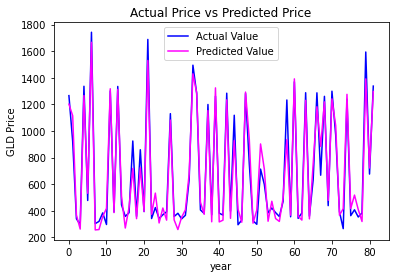

Performance obtained byLinear Regression
***************************************
***************************************
** RMSE: 90.750263   
** MSE: 8235.610267    
** MAE: 69.495978    
** R2 Score: 0.955955 
***************************************
***************************************


In [18]:
reg = LinearRegression().fit(X_train, Y_train)
pred = reg.predict(X_test)
Y_t = list(Y_test)
LRpred = pd.DataFrame(pred)
Plot(Y_t,pred)
model = "Linear Regression"
Performance(Y_test, LRpred, model)

# Neural Network

Epoch 1/150
11/11 [==============================] - 0s 893us/step - loss: 324852.1562
Epoch 2/150
11/11 [==============================] - 0s 744us/step - loss: 147843.1719
Epoch 3/150
11/11 [==============================] - 0s 744us/step - loss: 121730.4297
Epoch 4/150
11/11 [==============================] - 0s 694us/step - loss: 125916.2812
Epoch 5/150
11/11 [==============================] - 0s 645us/step - loss: 120831.1797
Epoch 6/150
11/11 [==============================] - 0s 645us/step - loss: 120244.7500
Epoch 7/150
11/11 [==============================] - 0s 744us/step - loss: 117360.8125
Epoch 8/150
11/11 [==============================] - 0s 645us/step - loss: 115070.3047
Epoch 9/150
11/11 [==============================] - 0s 694us/step - loss: 113912.1328
Epoch 10/150
11/11 [==============================] - 0s 645us/step - loss: 112161.0156
Epoch 11/150
11/11 [==============================] - 0s 744us/step - loss: 108759.0938
Epoch 12/150
11/11 [=====================

11/11 [==============================] - 0s 2ms/step - loss: 15142.3115
Epoch 96/150
11/11 [==============================] - 0s 893us/step - loss: 16208.3467
Epoch 97/150
11/11 [==============================] - 0s 893us/step - loss: 17362.9219
Epoch 98/150
11/11 [==============================] - 0s 942us/step - loss: 20842.9043
Epoch 99/150
11/11 [==============================] - 0s 893us/step - loss: 25395.7598
Epoch 100/150
11/11 [==============================] - 0s 744us/step - loss: 23728.1387
Epoch 101/150
11/11 [==============================] - 0s 843us/step - loss: 18499.0430
Epoch 102/150
11/11 [==============================] - 0s 843us/step - loss: 15550.6094
Epoch 103/150
11/11 [==============================] - 0s 794us/step - loss: 14905.9492
Epoch 104/150
11/11 [==============================] - 0s 893us/step - loss: 14396.0566
Epoch 105/150
11/11 [==============================] - 0s 843us/step - loss: 13996.1777
Epoch 106/150
11/11 [==============================]

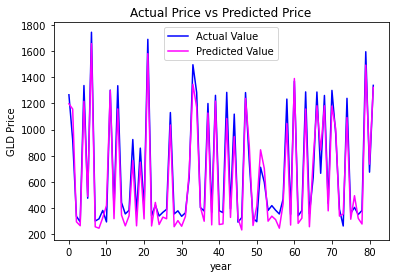

Performance obtained byNeural Network
***************************************
***************************************
** RMSE: 96.339938   
** MSE: 9281.383565    
** MAE: 84.591731    
** R2 Score: 0.950362 
***************************************
***************************************


In [19]:
NN = keras.Sequential()
NN.add(Dense(408, activation='relu'))
NN.add(Dense(64, activation='relu'))
NN.add(Dense(32, activation='relu'))
NN.add(Dense(1, activation='linear'))
NN.compile(loss='mse',optimizer='adam')
X_tr = np.asarray(X_train).astype(np.float32)
Y_tr = np.asarray(Y_train).astype(np.float32)
NN.fit(X_tr, Y_tr, epochs=150)
NNpred = NN.predict(X_test)
Y_t = np.array(Y_test, dtype=float)
Plot(Y_t, NNpred)
model = "Neural Network"
Performance(Y_test, NNpred, model)

# Random Forest 

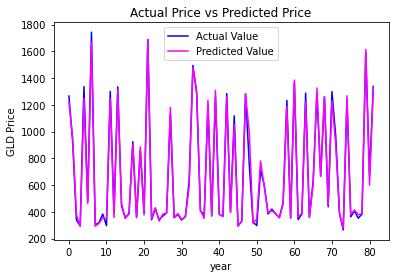

Performance obtained byRandom Forest
***************************************
***************************************
** RMSE: 40.470455   
** MSE: 1637.857751    
** MAE: 24.420709    
** R2 Score: 0.991240 
***************************************
***************************************


In [20]:
RF = RandomForestRegressor()
RF = RF.fit(X_train, Y_train);
RFpred = RF.predict(X_test)
Y_t = list(Y_test)
RFpred = pd.DataFrame(RFpred)
Plot(Y_t, RFpred)
model = "Random Forest"
Performance(Y_test, RFpred, model)

# LightGBM

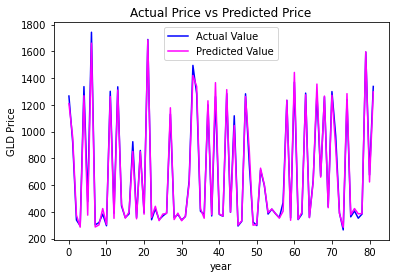

Performance obtained byLGBM
***************************************
***************************************
** RMSE: 37.509178   
** MSE: 1406.938461    
** MAE: 26.098297    
** R2 Score: 0.992475 
***************************************
***************************************


In [21]:
LGBM = lgb.LGBMRegressor()
Y = Y_train.astype('int32')
LGBM = LGBM.fit(X_train,Y)
LGBMpred = LGBM.predict(X_test)
Y_t = list(Y_test)
LGBMpred = pd.DataFrame(LGBMpred)
Plot(Y_t, LGBMpred)
model = "LGBM"
Performance(Y_test, LGBMpred, model)

# CatBoost algorithm

Learning rate set to 0.031971
0:	learn: 446.2103071	total: 153ms	remaining: 2m 33s
1:	learn: 435.0380881	total: 154ms	remaining: 1m 16s
2:	learn: 423.4475497	total: 155ms	remaining: 51.6s
3:	learn: 412.1579084	total: 156ms	remaining: 38.9s
4:	learn: 402.2026210	total: 157ms	remaining: 31.2s
5:	learn: 391.5784965	total: 158ms	remaining: 26.1s
6:	learn: 381.3284377	total: 159ms	remaining: 22.5s
7:	learn: 371.3818532	total: 160ms	remaining: 19.8s
8:	learn: 361.6576606	total: 161ms	remaining: 17.7s
9:	learn: 352.4412245	total: 162ms	remaining: 16s
10:	learn: 343.4189725	total: 163ms	remaining: 14.6s
11:	learn: 334.7179518	total: 164ms	remaining: 13.5s
12:	learn: 325.8422990	total: 164ms	remaining: 12.5s
13:	learn: 318.1521007	total: 165ms	remaining: 11.7s
14:	learn: 310.3415619	total: 166ms	remaining: 10.9s
15:	learn: 302.3016355	total: 167ms	remaining: 10.3s
16:	learn: 294.8545226	total: 168ms	remaining: 9.72s
17:	learn: 287.4394443	total: 169ms	remaining: 9.21s
18:	learn: 280.2118511	tot

175:	learn: 31.0884312	total: 327ms	remaining: 1.53s
176:	learn: 30.9456706	total: 329ms	remaining: 1.53s
177:	learn: 30.8650431	total: 331ms	remaining: 1.53s
178:	learn: 30.7460905	total: 333ms	remaining: 1.53s
179:	learn: 30.5633467	total: 336ms	remaining: 1.53s
180:	learn: 30.4114203	total: 340ms	remaining: 1.54s
181:	learn: 30.2803510	total: 343ms	remaining: 1.54s
182:	learn: 30.1720675	total: 346ms	remaining: 1.54s
183:	learn: 30.0616669	total: 349ms	remaining: 1.55s
184:	learn: 30.0183824	total: 352ms	remaining: 1.55s
185:	learn: 29.9052598	total: 355ms	remaining: 1.55s
186:	learn: 29.7490106	total: 357ms	remaining: 1.55s
187:	learn: 29.6364291	total: 360ms	remaining: 1.55s
188:	learn: 29.5949950	total: 362ms	remaining: 1.55s
189:	learn: 29.4988608	total: 365ms	remaining: 1.56s
190:	learn: 29.4327477	total: 368ms	remaining: 1.56s
191:	learn: 29.3447363	total: 371ms	remaining: 1.56s
192:	learn: 29.2490180	total: 373ms	remaining: 1.56s
193:	learn: 29.1872271	total: 376ms	remaining:

339:	learn: 21.3336711	total: 513ms	remaining: 997ms
340:	learn: 21.3275529	total: 514ms	remaining: 994ms
341:	learn: 21.2358812	total: 515ms	remaining: 991ms
342:	learn: 21.1464879	total: 516ms	remaining: 988ms
343:	learn: 21.0604586	total: 517ms	remaining: 985ms
344:	learn: 20.9890507	total: 517ms	remaining: 982ms
345:	learn: 20.9228463	total: 518ms	remaining: 979ms
346:	learn: 20.9071250	total: 519ms	remaining: 976ms
347:	learn: 20.9023745	total: 520ms	remaining: 973ms
348:	learn: 20.8224145	total: 520ms	remaining: 971ms
349:	learn: 20.7729279	total: 521ms	remaining: 968ms
350:	learn: 20.6879170	total: 522ms	remaining: 965ms
351:	learn: 20.6699008	total: 523ms	remaining: 962ms
352:	learn: 20.5939663	total: 523ms	remaining: 959ms
353:	learn: 20.5116081	total: 524ms	remaining: 956ms
354:	learn: 20.4443805	total: 525ms	remaining: 953ms
355:	learn: 20.4306915	total: 525ms	remaining: 951ms
356:	learn: 20.4157584	total: 526ms	remaining: 948ms
357:	learn: 20.3440160	total: 527ms	remaining:

655:	learn: 11.9750361	total: 849ms	remaining: 445ms
656:	learn: 11.9596260	total: 850ms	remaining: 444ms
657:	learn: 11.9355531	total: 851ms	remaining: 442ms
658:	learn: 11.9260710	total: 852ms	remaining: 441ms
659:	learn: 11.9145041	total: 853ms	remaining: 439ms
660:	learn: 11.9035010	total: 853ms	remaining: 438ms
661:	learn: 11.8866274	total: 854ms	remaining: 436ms
662:	learn: 11.8668438	total: 855ms	remaining: 434ms
663:	learn: 11.8559911	total: 856ms	remaining: 433ms
664:	learn: 11.8255302	total: 857ms	remaining: 431ms
665:	learn: 11.8134864	total: 857ms	remaining: 430ms
666:	learn: 11.8058631	total: 858ms	remaining: 428ms
667:	learn: 11.7969729	total: 859ms	remaining: 427ms
668:	learn: 11.7948986	total: 860ms	remaining: 425ms
669:	learn: 11.7817451	total: 861ms	remaining: 424ms
670:	learn: 11.7587663	total: 862ms	remaining: 423ms
671:	learn: 11.7474905	total: 863ms	remaining: 421ms
672:	learn: 11.7374553	total: 865ms	remaining: 420ms
673:	learn: 11.7244461	total: 866ms	remaining:

956:	learn: 8.5207048	total: 1.2s	remaining: 54ms
957:	learn: 8.5181458	total: 1.2s	remaining: 52.8ms
958:	learn: 8.5044980	total: 1.21s	remaining: 51.6ms
959:	learn: 8.4970541	total: 1.21s	remaining: 50.4ms
960:	learn: 8.4899843	total: 1.21s	remaining: 49.2ms
961:	learn: 8.4853589	total: 1.22s	remaining: 48.1ms
962:	learn: 8.4757354	total: 1.22s	remaining: 46.9ms
963:	learn: 8.4634734	total: 1.22s	remaining: 45.6ms
964:	learn: 8.4573430	total: 1.22s	remaining: 44.4ms
965:	learn: 8.4473380	total: 1.22s	remaining: 43.1ms
966:	learn: 8.4448172	total: 1.23s	remaining: 41.8ms
967:	learn: 8.4414608	total: 1.23s	remaining: 40.6ms
968:	learn: 8.4372769	total: 1.23s	remaining: 39.3ms
969:	learn: 8.4363838	total: 1.23s	remaining: 38.1ms
970:	learn: 8.4338670	total: 1.23s	remaining: 36.8ms
971:	learn: 8.4258757	total: 1.23s	remaining: 35.5ms
972:	learn: 8.4216287	total: 1.24s	remaining: 34.3ms
973:	learn: 8.4197466	total: 1.24s	remaining: 33ms
974:	learn: 8.4090353	total: 1.24s	remaining: 31.8ms

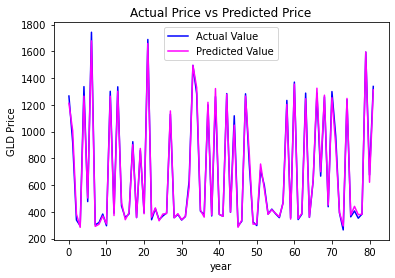

Performance obtained byCatBoost
***************************************
***************************************
** RMSE: 29.610148   
** MSE: 876.760854    
** MAE: 21.310638    
** R2 Score: 0.995311 
***************************************
***************************************


In [22]:
CatB = CatBoostRegressor()
Y = Y_train.astype('int32')
CatB = CatB.fit(X_train,Y)
CatBpred = CatB.predict(X_test)
Y_t = list(Y_test)
CatBpred = pd.DataFrame(CatBpred)
Plot(Y_t, CatBpred)
model = "CatBoost"
Performance(Y_test, CatBpred, model)

# XGBoost

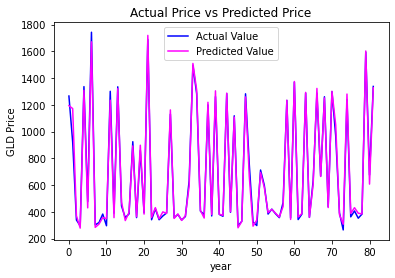

Performance obtained byXGBoost
***************************************
***************************************
** RMSE: 40.364454   
** MSE: 1629.289130    
** MAE: 24.617851    
** R2 Score: 0.991286 
***************************************
***************************************


In [23]:
XGB = xgb.XGBRegressor()
XGB = XGB.fit(X_train,Y_train)
XGBpred = XGB.predict(X_test)
Y_t = list(Y_test)
XGBpred = pd.DataFrame(XGBpred)
Plot(Y_t, XGBpred)
model = "XGBoost"
Performance(Y_test, XGBpred, model)

# SHAP values analysis

Linear Regression:


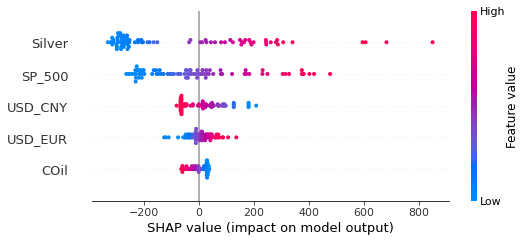

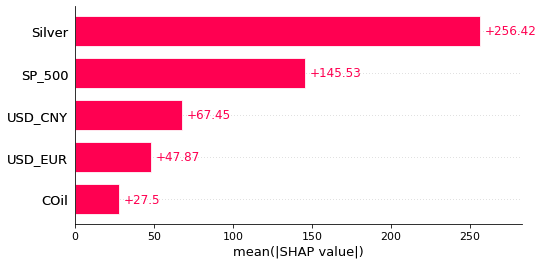

***********************************************************************
Random Forest:


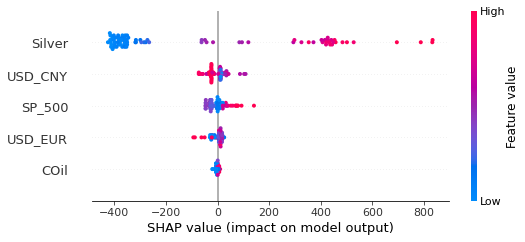

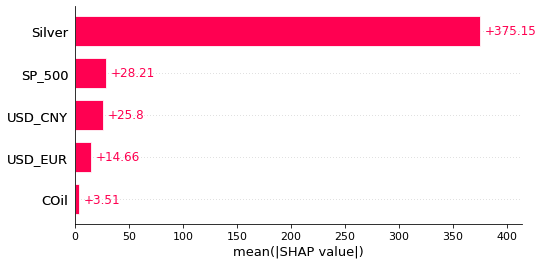

***********************************************************************
LGB:


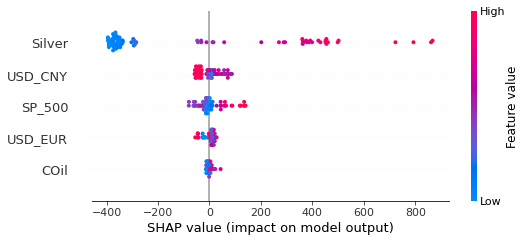

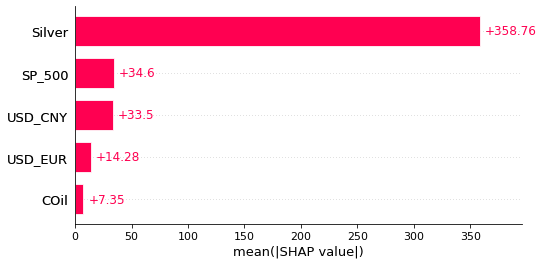

***********************************************************************
XGB:


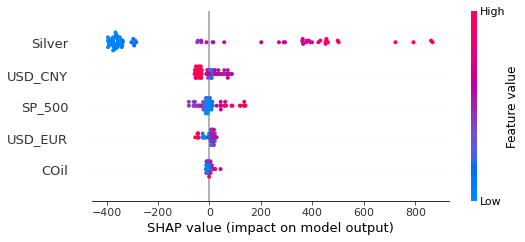

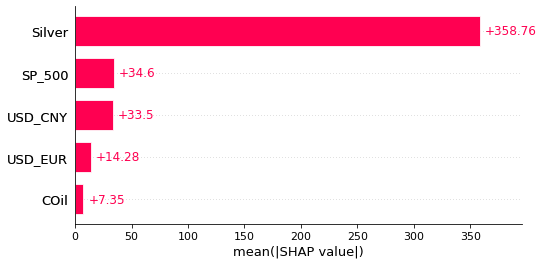

In [25]:
print("Linear Regression:")
SHAPBeeswarm(reg, X_train, X_test)
SHAPBarPlot(reg, X_train, X_test)
print("***********************************************************************")
print("Random Forest:")
SHAPBeeswarm(RF, X_train, X_test)
SHAPBarPlot(RF, X_train, X_test)
print("***********************************************************************")
print("LGB:")
SHAPBeeswarm(LGBM, X_train, X_test)
SHAPBarPlot(LGBM, X_train, X_test)
print("***********************************************************************")
print("XGB:")
SHAPBeeswarm(LGBM, X_train, X_test)
SHAPBarPlot(LGBM, X_train, X_test)

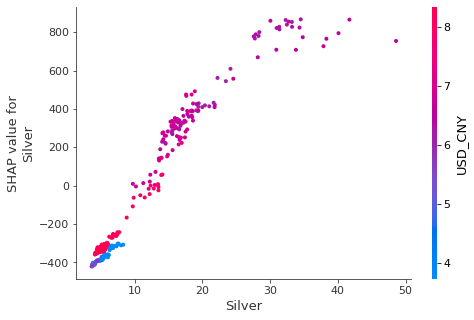

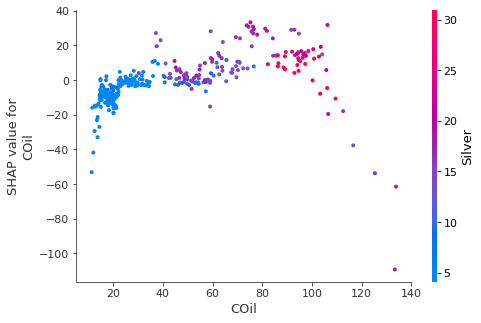

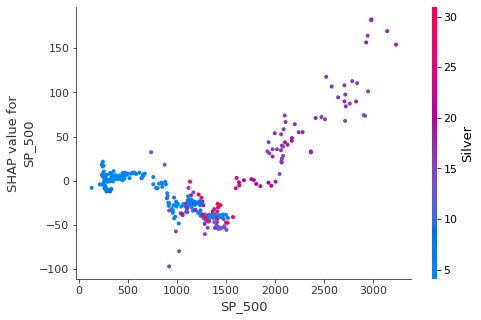

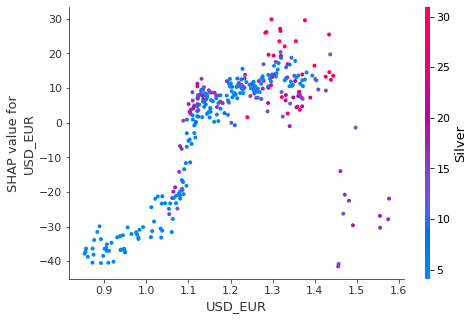

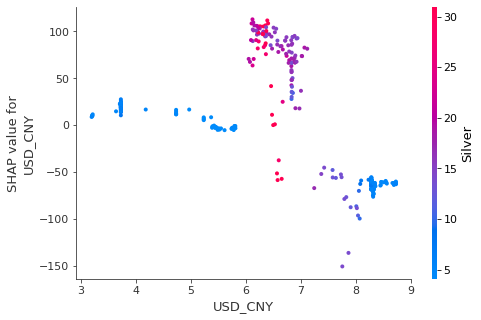

In [24]:
SHAPDepPlot(XGB, X_train)

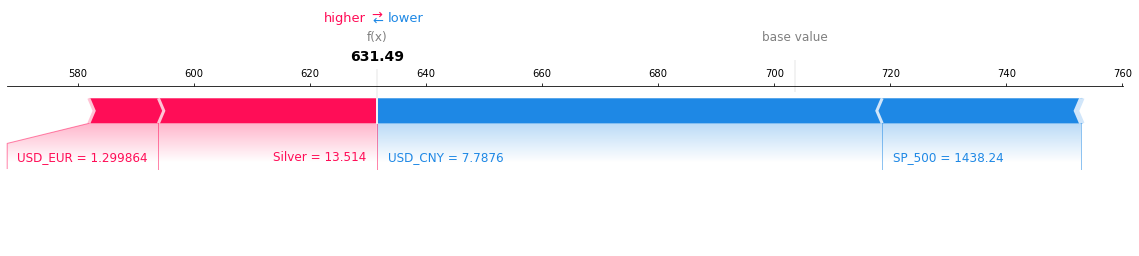

In [58]:
SHAPForcePlot(XGB,  X_train)

Nel caso appena presentato la differenza rispetto al grafico presentato nell'articolo è dovuta alla mancanza di due dataset,il che comporta un diverso bilanciamento dell' influenza